In [46]:
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from kb_python.utils import import_matrix_as_anndata
from sklearn.linear_model import LinearRegression
from upsetplot import from_contents, from_indicators
from upsetplot import plot as upset
from mx.mx_inspect import mx_inspect_rows, mx_inspect_cols
fsize = 15
import muon


def nd(arr):
    return np.asarray(arr).reshape(-1)


def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, c="k", alpha=0.75, zorder=0)
    ax.set(**{"aspect": "equal", "xlim": lims, "ylim": lims})
    return ax


plt.rcParams.update({"font.size": fsize})
%config InlineBackend.figure_format = 'retina'

In [47]:
mu = muon.read_h5mu("/home/sina/projects/atac/scATAK/data/shareseqv2/bmmc/mu.h5mu")

In [48]:
print(mu.mod["atac"].shape, mu.mod["gene"].shape, sep="\n")

(6934364, 78931)
(6505018, 60664)


In [50]:
muon.pp.intersect_obs(mu)

In [51]:
print(mu.mod["atac"].shape, mu.mod["gene"].shape, sep="\n")

(6421847, 78931)
(6421847, 60664)


In [53]:
print(f"Gene: {mu.mod['gene'].X.sum():,.0f}")
print(f"ATAC: {mu.mod['atac'].X.sum():,.0f}")

Gene: 83,762,304
ATAC: 214,827,136


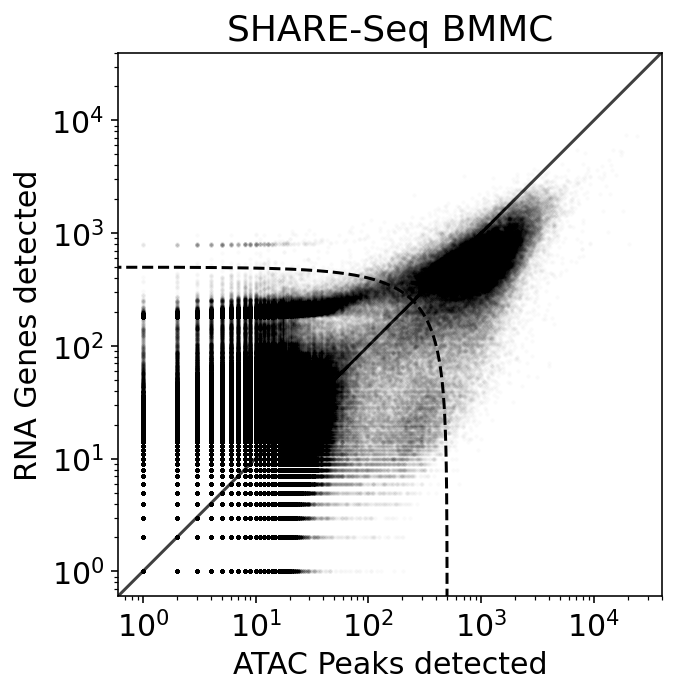

In [58]:
fig, ax = plt.subplots(figsize=(5,5))

x = mu.obs["atac:counts_nnzero"]
y = mu.obs["gene:counts_nnzero"]

ax.scatter(x,y, s=2, alpha=0.01, color="k")
xx = np.arange(x.min(), x.max())
y = -xx + 500
ax.plot(xx, y, color="k", linestyle="--")

ax.set(**{
    "title": "SHARE-Seq BMMC",
    "xlabel": "ATAC Peaks detected",
    "ylabel": "RNA Genes detected",
    "xscale": "log",
    "yscale": "log"
})
yex(ax)
fig.show()

In [60]:
dfa = pd.read_csv("/home/sina/projects/atac/scATAK/data/shareseqv2/bmmc/geo_data/tbl.atac", sep="\t", index_col=0)
dfg = pd.read_csv("/home/sina/projects/atac/scATAK/data/shareseqv2/bmmc/geo_data/tbl.rna", sep="\t", index_col=0)

common = np.intersect1d(dfa.index, dfg.index)

dfa = dfa.loc[common]
dfg = dfg.loc[common]

In [62]:
fmu = mu[common].copy()

In [63]:
fmu.shape

(99228, 139595)

In [65]:
print(fmu.mod["gene"].shape, fmu.mod["atac"].shape, sep="\n")

(99228, 60664)
(99228, 78931)


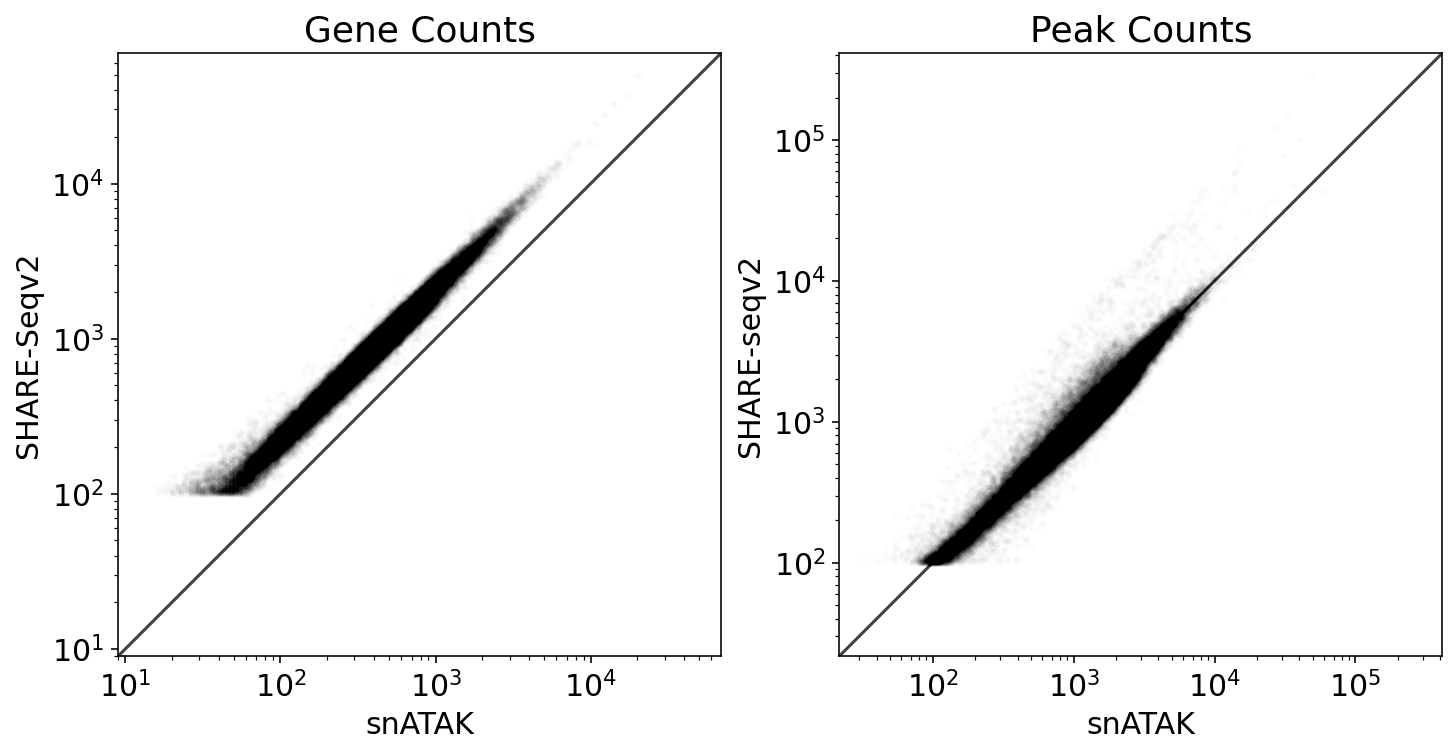

In [69]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2, constrained_layout=True)

ax = axs[0]
x = fmu.obs["gene:counts_sum"]
y = dfg["hg19_unique"]

ax.scatter(x,y, s=5, alpha=0.01, color="k")

ax.set(**{
    "title": "Gene Counts",
    "xlabel": "snATAK",
    "ylabel": "SHARE-Seqv2",
    "xscale": "log",
    "yscale": "log"
})
yex(ax)

ax = axs[1]
x = fmu.obs["atac:counts_sum"]
y = dfa["hg19_unique"]

ax.scatter(x,y, s=5, alpha=0.01, color="k")

ax.set(**{
    "title": "Peak Counts",
    "xlabel": "snATAK",
    "ylabel": "SHARE-seqv2",
    "xscale": "log",
    "yscale": "log"
})
yex(ax)
fig.show()

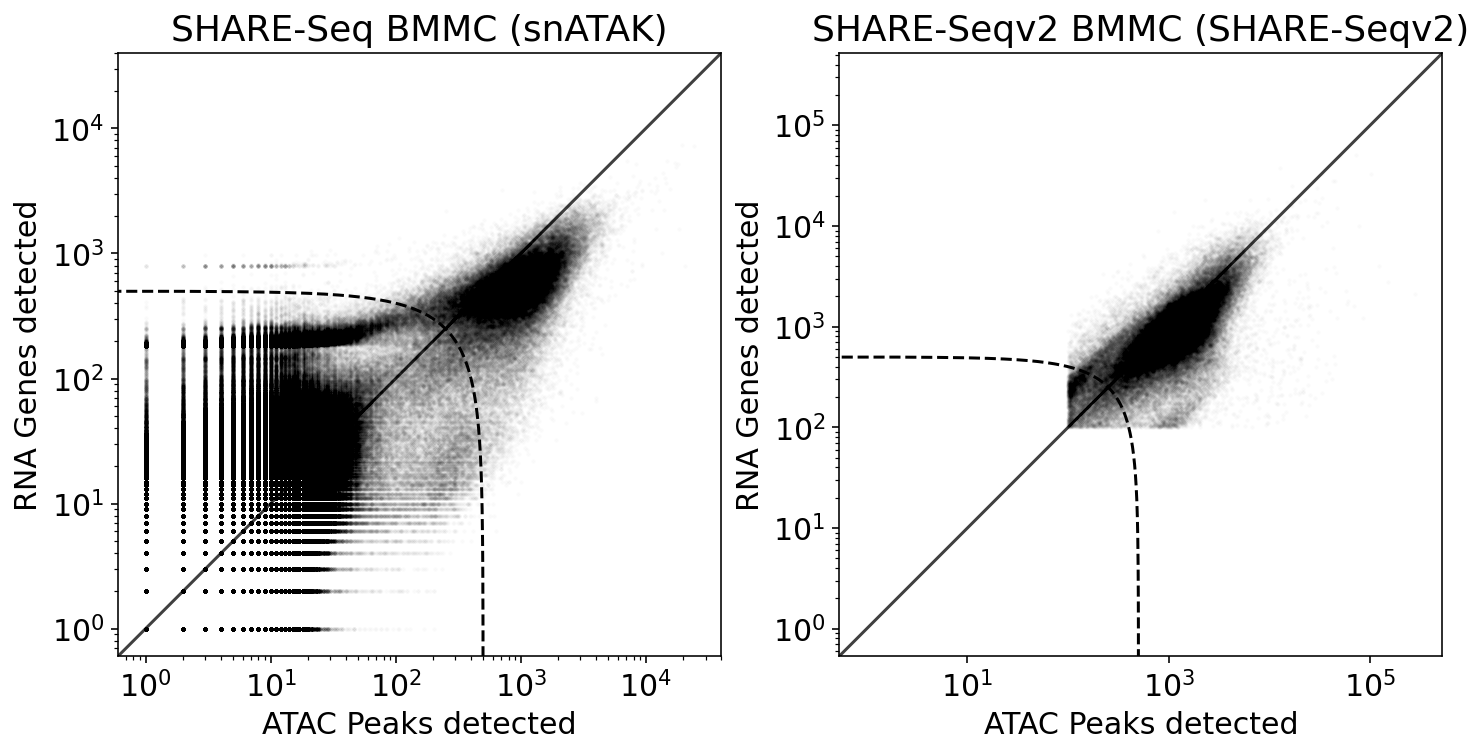

In [68]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2, constrained_layout=True)

ax = axs[0]
x = mu.obs["atac:counts_nnzero"]
y = mu.obs["gene:counts_nnzero"]

ax.scatter(x,y, s=2, alpha=0.01, color="k")
xx = np.arange(x.min(), x.max())
y = -xx + 500
ax.plot(xx, y, color="k", linestyle="--")

ax.set(**{
    "title": "SHARE-Seq BMMC (snATAK)",
    "xlabel": "ATAC Peaks detected",
    "ylabel": "RNA Genes detected",
    "xscale": "log",
    "yscale": "log"
})
yex(ax)


ax = axs[1]
x = dfa["hg19_unique"]
y = dfg["hg19_unique"]

ax.scatter(x,y, s=2, alpha=0.01, color="k")
xx = np.arange(x.min(), x.max())
y = -xx + 500
ax.plot(xx, y, color="k", linestyle="--")

ax.set(**{
    "title": "SHARE-Seqv2 BMMC (SHARE-Seqv2)",
    "xlabel": "ATAC Peaks detected",
    "ylabel": "RNA Genes detected",
    "xscale": "log",
    "yscale": "log"
})
yex(ax)

## fig.savefig("figures/shareseq_bmmc_cmp.png", bbox_inches="tight", dpi=300)
fig.show()

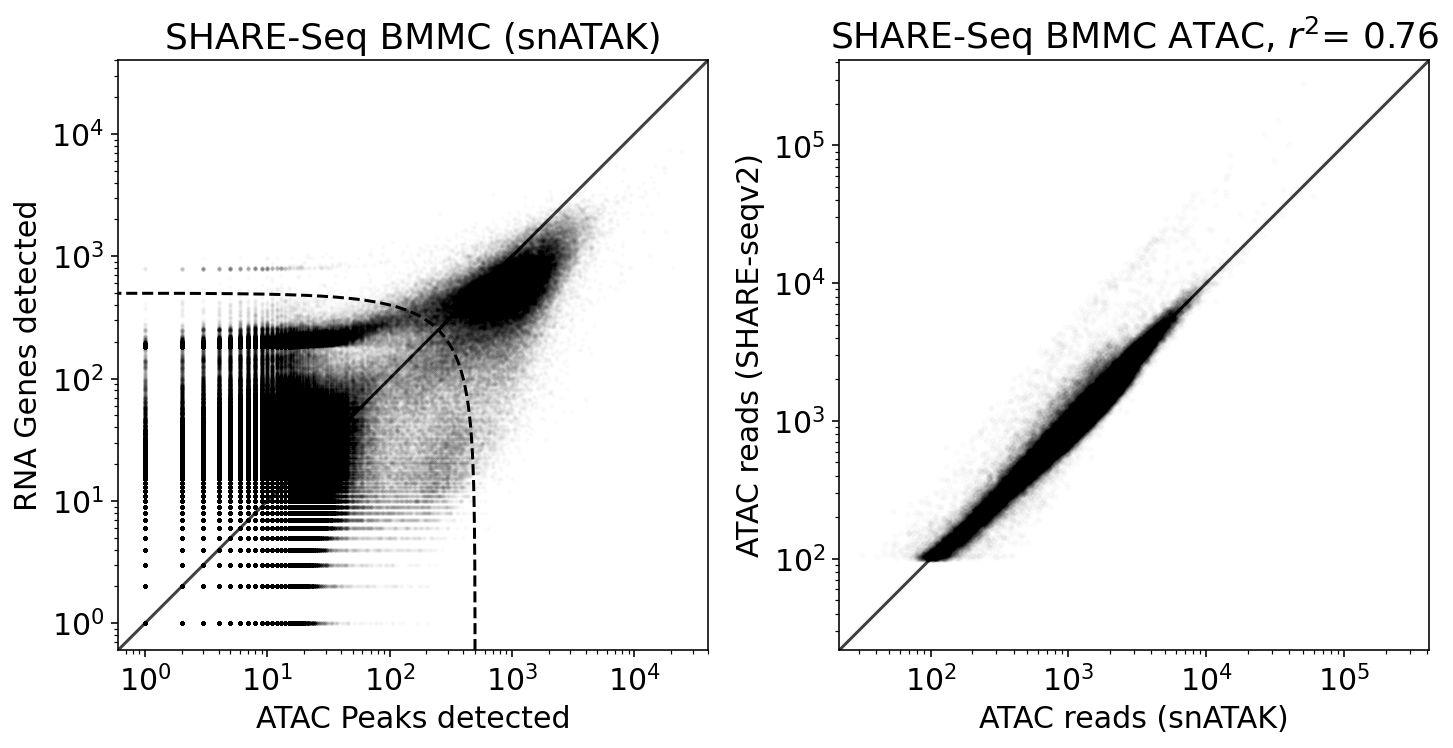

In [71]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2, constrained_layout=True)

ax = axs[0]
x = mu.obs["atac:counts_nnzero"].values
y = mu.obs["gene:counts_nnzero"].values

ax.scatter(x,y, s=2, alpha=0.01, color="k")
xx = np.arange(x.min(), x.max())
y = -xx + 500
ax.plot(xx, y, color="k", linestyle="--")

ax.set(**{
    "title": "SHARE-Seq BMMC (snATAK)",
    "xlabel": "ATAC Peaks detected",
    "ylabel": "RNA Genes detected",
    "xscale": "log",
    "yscale": "log"
})
yex(ax)

ax = axs[1]
x = fmu.obs["atac:counts_sum"].values
y = dfa["hg19_unique"].values

ax.scatter(x,y, s=5, alpha=0.01, color="k")

lx, ly = np.log1p(x.reshape(-1,1)), np.log1p(y)
reg = LinearRegression().fit(lx, ly)
r2 = reg.score(lx, ly)

ax.set(**{
    "title": f"SHARE-Seq BMMC ATAC, $r^2$= {r2:,.2f}",
    "xlabel": "ATAC reads (snATAK)",
    "ylabel": "ATAC reads (SHARE-seqv2)",
    "xscale": "log",
    "yscale": "log"
})
yex(ax)

fig.savefig("figures/shareseq_bmmc_cmp.png", bbox_inches="tight", dpi=300)
fig.show()

In [72]:
# from mx.mx_normalize import mx_normalize

# fmg = anndata.AnnData(fmtx, pd.DataFrame(index=fbcs), mg.var)
# fmg.layers["raw"] = fmtx
# fmg.layers["log1pPF"] = mx_normalize(fmtx, method="log1pPF")
# fmg.X = fmg.layers["log1pPF"]

# import scanpy as sc

# sc.pp.neighbors(fmg)

# sc.tl.leiden(fmg)

# fmg.obs.to_csv("/home/sina/projects/atac/scATAK/data/shareseqv2/data/bmmc/out_gene/clustering.txt", sep="\t", header=None)

# fmg.shape